# Smoothing with Wave Transform Preprocessing

In [1]:
%load_ext autoreload
%autoreload 2
p = print

from os.path import join

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

from crypr.util import get_project_path
from crypr.build import data_to_supervised, make_3d
from crypr.transformers import HaarSmoothTransformer, PassthroughTransformer, PercentChangeTransformer

In [2]:
SYM = 'BTC'
TARGET = 'close'
Tx = 72
Ty = 1
TEST_SIZE = 0.05
data_path = join(get_project_path(), 'data', 'raw', SYM + '.csv')

In [3]:
raw_data = pd.read_csv(data_path, index_col=0)[['close']]

train_data, test_data = train_test_split(raw_data, test_size=TEST_SIZE, shuffle=False)
train_data.head()

,close
0,6990.50
1,6994.01
2,6987.21
3,6999.45
4,6992.18


In [4]:
"""
Get percent change feature and target data.
"""
def apply_pct_change(data):
    arr = PercentChangeTransformer().fit_transform(data)
    return pd.DataFrame(arr, columns=['pct_change__close']).dropna()

train_data = apply_pct_change(train_data)
test_data = apply_pct_change(test_data).iloc[:-1]
p(train_data.shape, test_data.shape)
train_data.head()

(5698, 1) (298, 1)


,pct_change__close
1,0.050211
2,-0.097226
3,0.175177
4,-0.103865
5,0.075942


In [5]:
def apply_haar_smooth(data):
    transformers = [
        ('orig', PassthroughTransformer(), ['pct_change__close']),
        ('haar_smooth', HaarSmoothTransformer(.4), ['pct_change__close']),
    ]
    ct = ColumnTransformer(transformers=transformers, remainder='drop', n_jobs=-1)
    return pd.DataFrame(data=ct.fit_transform(data), columns=ct.get_feature_names())

train_smooth = apply_haar_smooth(train_data)
test_smooth = apply_haar_smooth(test_data)

train_smooth.head()

,orig__pct_change__close,haar_smooth__pct_change__close
0,0.050211,0.0
1,-0.097226,0.0
2,0.175177,0.0
3,-0.103865,0.0
4,0.075942,0.0


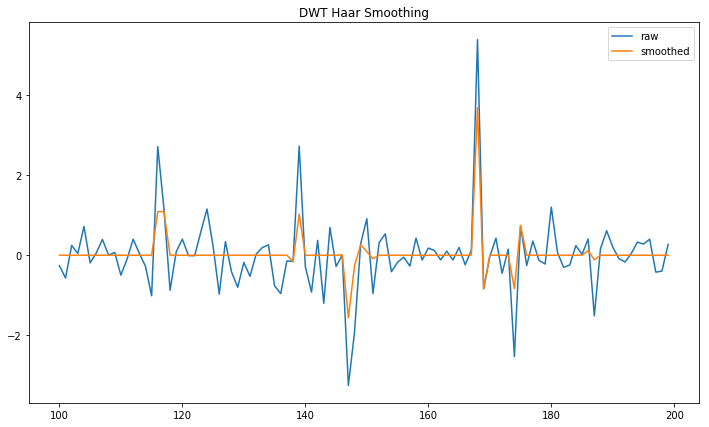

In [6]:
"""
Visualize
"""
sample_ix = 100
sample_n = 100
sample = train_smooth.iloc[sample_ix:sample_ix + sample_n]

fig, ax = plt.subplots(figsize=(12, 7))
plt.plot(sample['orig__pct_change__close'], label='raw')
plt.plot(sample['haar_smooth__pct_change__close'], label='smoothed')
plt.title('DWT Haar Smoothing')
plt.legend()
plt.show()

In [7]:
"""
Create time-series samples.
"""
X_train, y_train = data_to_supervised(train_smooth, target_ix=-1, Tx=Tx, Ty=Ty)
X_test, y_test = data_to_supervised(test_smooth, target_ix=-1, Tx=Tx, Ty=Ty)
X_train = make_3d(X_train, tx=Tx, num_channels=2)
X_test = make_3d(X_test, tx=Tx, num_channels=2)

In [8]:
"""
Save data.
"""
output_dir = join(get_project_path(), 'data', 'processed')

np.save(arr=X_train, file=join(output_dir, 'X_train_smooth_{}.npy'.format(SYM)))
np.save(arr=X_test,  file=join(output_dir, 'X_test_smooth_{}.npy'.format(SYM)))
np.save(arr=y_train, file=join(output_dir, 'y_train_smooth_{}.npy'.format(SYM)))
np.save(arr=y_test,  file=join(output_dir, 'y_test_smooth_{}.npy'.format(SYM)))